In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib
import os

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from IPython.display import display

### Load Dataset

In [3]:
df = pd.read_csv('diabetes_dataset00.csv')

# Exploratory Data Analysis (EDA)

### Basic statistics

missing values

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

Target                           0
Genetic Markers                  0
Autoantibodies                   0
Family History                   0
Environmental Factors            0
Insulin Levels                   0
Age                              0
BMI                              0
Physical Activity                0
Dietary Habits                   0
Blood Pressure                   0
Cholesterol Levels               0
Waist Circumference              0
Blood Glucose Levels             0
Ethnicity                        0
Socioeconomic Factors            0
Smoking Status                   0
Alcohol Consumption              0
Glucose Tolerance Test           0
History of PCOS                  0
Previous Gestational Diabetes    0
Pregnancy History                0
Weight Gain During Pregnancy     0
Pancreatic Health                0
Pulmonary Function               0
Cystic Fibrosis Diagnosis        0
Steroid Use History              0
Genetic Testing                  0
Neurological Assessm

duplicate values

In [5]:
duplicated_values = df.duplicated().sum()
duplicated_values

0

data types & details

In [6]:
def column_summary(df):
    summary_data = []
    
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), 
                                     key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summary(df)
summary_df

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Target,object,0,70000,13,"{'MODY': 5553, 'Secondary Diabetes': 5479, 'Cy..."
1,Genetic Markers,object,0,70000,2,"{'Positive': 35101, 'Negative': 34899}"
2,Autoantibodies,object,0,70000,2,"{'Negative': 35058, 'Positive': 34942}"
3,Family History,object,0,70000,2,"{'Yes': 35168, 'No': 34832}"
4,Environmental Factors,object,0,70000,2,"{'Absent': 35088, 'Present': 34912}"
5,Insulin Levels,int64,0,70000,45,"{13: 3099, 14: 3049, 18: 3044, 10: 3028, 11: 3..."
6,Age,int64,0,70000,80,"{1: 3165, 0: 2655, 10: 1493, 14: 1437, 11: 140..."
7,BMI,int64,0,70000,28,"{24: 4864, 27: 4184, 26: 4146, 25: 4080, 28: 4..."
8,Physical Activity,object,0,70000,3,"{'Moderate': 23427, 'Low': 23348, 'High': 23225}"
9,Dietary Habits,object,0,70000,2,"{'Healthy': 35020, 'Unhealthy': 34980}"


summary for numerical features

In [7]:
df.describe()

,Insulin Levels,Age,BMI,Blood Pressure,Cholesterol Levels,Waist Circumference,Blood Glucose Levels,Weight Gain During Pregnancy,Pancreatic Health,Pulmonary Function,Neurological Assessments,Digestive Enzyme Levels,Birth Weight
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,21.607443,32.020700,24.782943,111.339543,194.867200,35.051657,160.701657,15.496414,47.564243,70.264671,1.804157,46.420529,3097.061071
std,10.785852,21.043173,6.014236,19.945000,44.532466,6.803461,48.165547,9.633096,19.984683,11.965600,0.680154,19.391089,713.837300
min,5.000000,0.000000,12.000000,60.000000,100.000000,20.000000,80.000000,0.000000,10.000000,30.000000,1.000000,10.000000,1500.000000
25%,13.000000,14.000000,20.000000,99.000000,163.000000,30.000000,121.000000,7.000000,32.000000,63.000000,1.000000,31.000000,2629.000000
50%,19.000000,31.000000,25.000000,113.000000,191.000000,34.000000,152.000000,16.000000,46.000000,72.000000,2.000000,48.000000,3103.000000
75%,28.000000,49.000000,29.000000,125.000000,225.000000,39.000000,194.000000,22.000000,64.000000,79.000000,2.000000,61.000000,3656.250000
max,49.000000,79.000000,39.000000,149.000000,299.000000,54.000000,299.000000,39.000000,99.000000,89.000000,3.000000,99.000000,4499.000000


### Class distribution

Separate column category

In [8]:
# Categorizing columns into different types

# Target variable (multi-class classification)
target_column = ["Target"]

# Numerical features (Continuous Variables)
numerical_features = [
    "Insulin Levels", "Age", "BMI", "Blood Pressure", "Cholesterol Levels",
    "Waist Circumference", "Blood Glucose Levels", "Weight Gain During Pregnancy",
    "Pancreatic Health", "Pulmonary Function", "Neurological Assessments",
    "Digestive Enzyme Levels", "Birth Weight"
]

# Categorical features (Binary or Discrete Categories)
categorical_features = [
    "Genetic Markers", "Autoantibodies", "Family History", "Environmental Factors",
    "Physical Activity", "Dietary Habits", "Ethnicity", "Socioeconomic Factors",
    "Smoking Status", "Alcohol Consumption", "Glucose Tolerance Test",
    "History of PCOS", "Previous Gestational Diabetes", "Pregnancy History",
    "Cystic Fibrosis Diagnosis", "Steroid Use History", "Genetic Testing",
    "Liver Function Tests", "Urine Test", "Early Onset Symptoms"
]

check distribution for numerical features

In [9]:
def plot_numerical_analysis(df, numerical_features):
    # Define layout parameters
    columns_per_row = 4  # Adjust number of columns per row for better visualization
    num_columns = len(numerical_features)
    num_rows = math.ceil(num_columns / columns_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(16, num_rows * 4))
    axes = axes.flatten()  # Flatten for easier iteration

    # Loop through numerical features and create histograms
    for idx, column in enumerate(numerical_features):
        ax = axes[idx]  # Select the appropriate subplot
        sns.histplot(df[column], kde=True, ax=ax, bins=20, color='royalblue')  # Histogram with KDE
        ax.set_title(f'Histogram of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    # Hide unused subplots if any
    for idx in range(num_columns, len(axes)):
        axes[idx].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


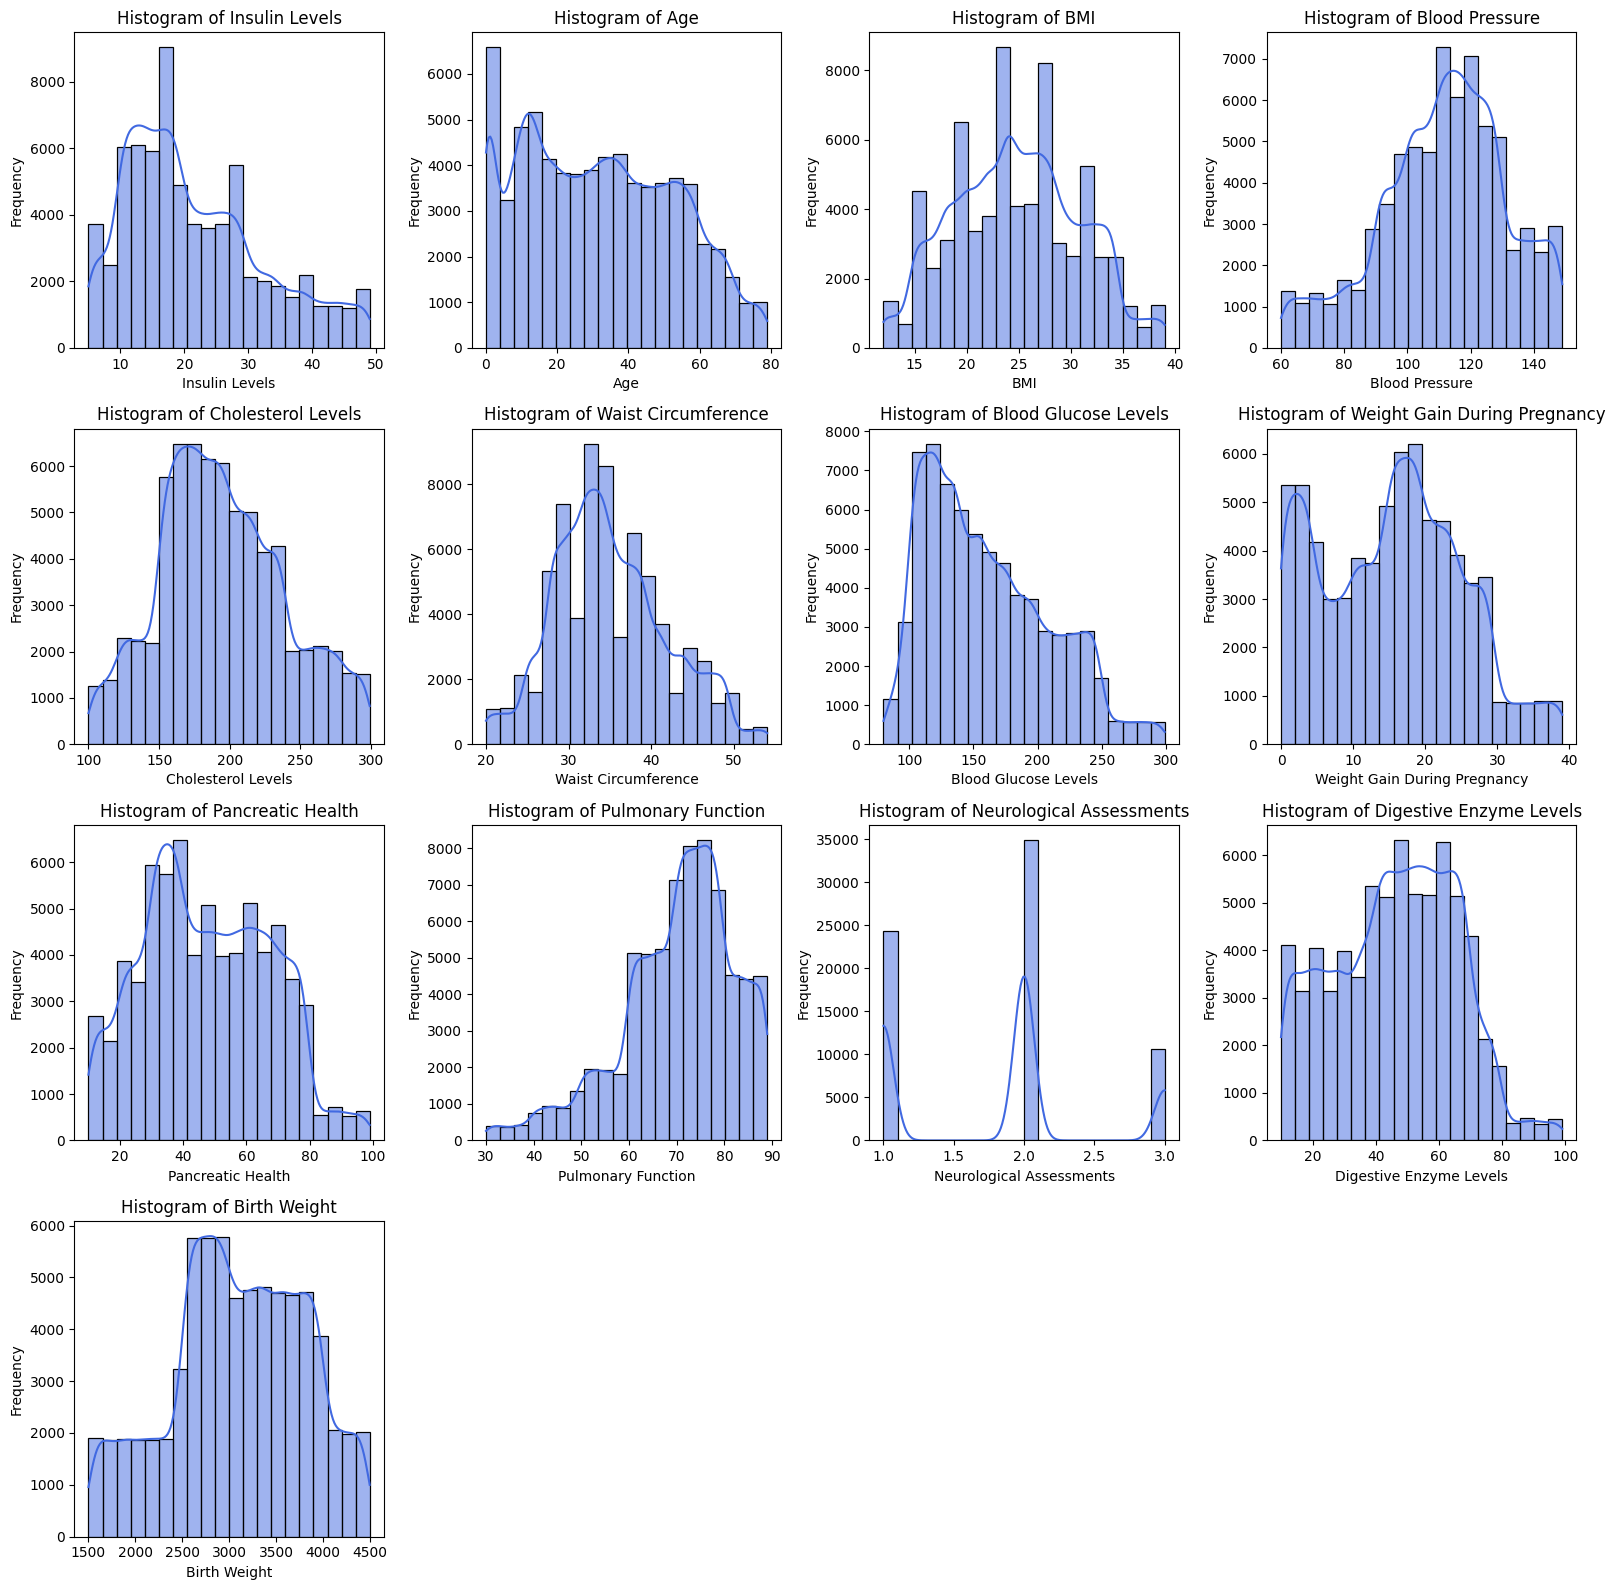

In [10]:
plot_numerical_analysis(df, numerical_features)

check distribution for categorical features

In [11]:
def plot_categorical_analysis(df, categorical_features):
    # Define layout parameters
    columns_per_row = 4  # Adjust number of columns per row for better visualization
    num_columns = len(categorical_features)
    num_rows = math.ceil(num_columns / columns_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(16, num_rows * 4))
    axes = axes.flatten()  # Flatten for easier iteration

    # Loop through categorical features and create count plots
    for idx, column in enumerate(categorical_features):
        ax = axes[idx]  # Select the appropriate subplot
        sns.countplot(x=df[column], ax=ax, palette="coolwarm")
        ax.set_title(f'Count Plot of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability

    # Hide unused subplots if any
    for idx in range(num_columns, len(axes)):
        axes[idx].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\2000149453.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column], ax=ax, palette="coolwarm")
C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\2000149453.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability
C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\2000149453.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column], ax=ax, palette="coolwarm")
C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\2000149453.py:18: UserWarning:

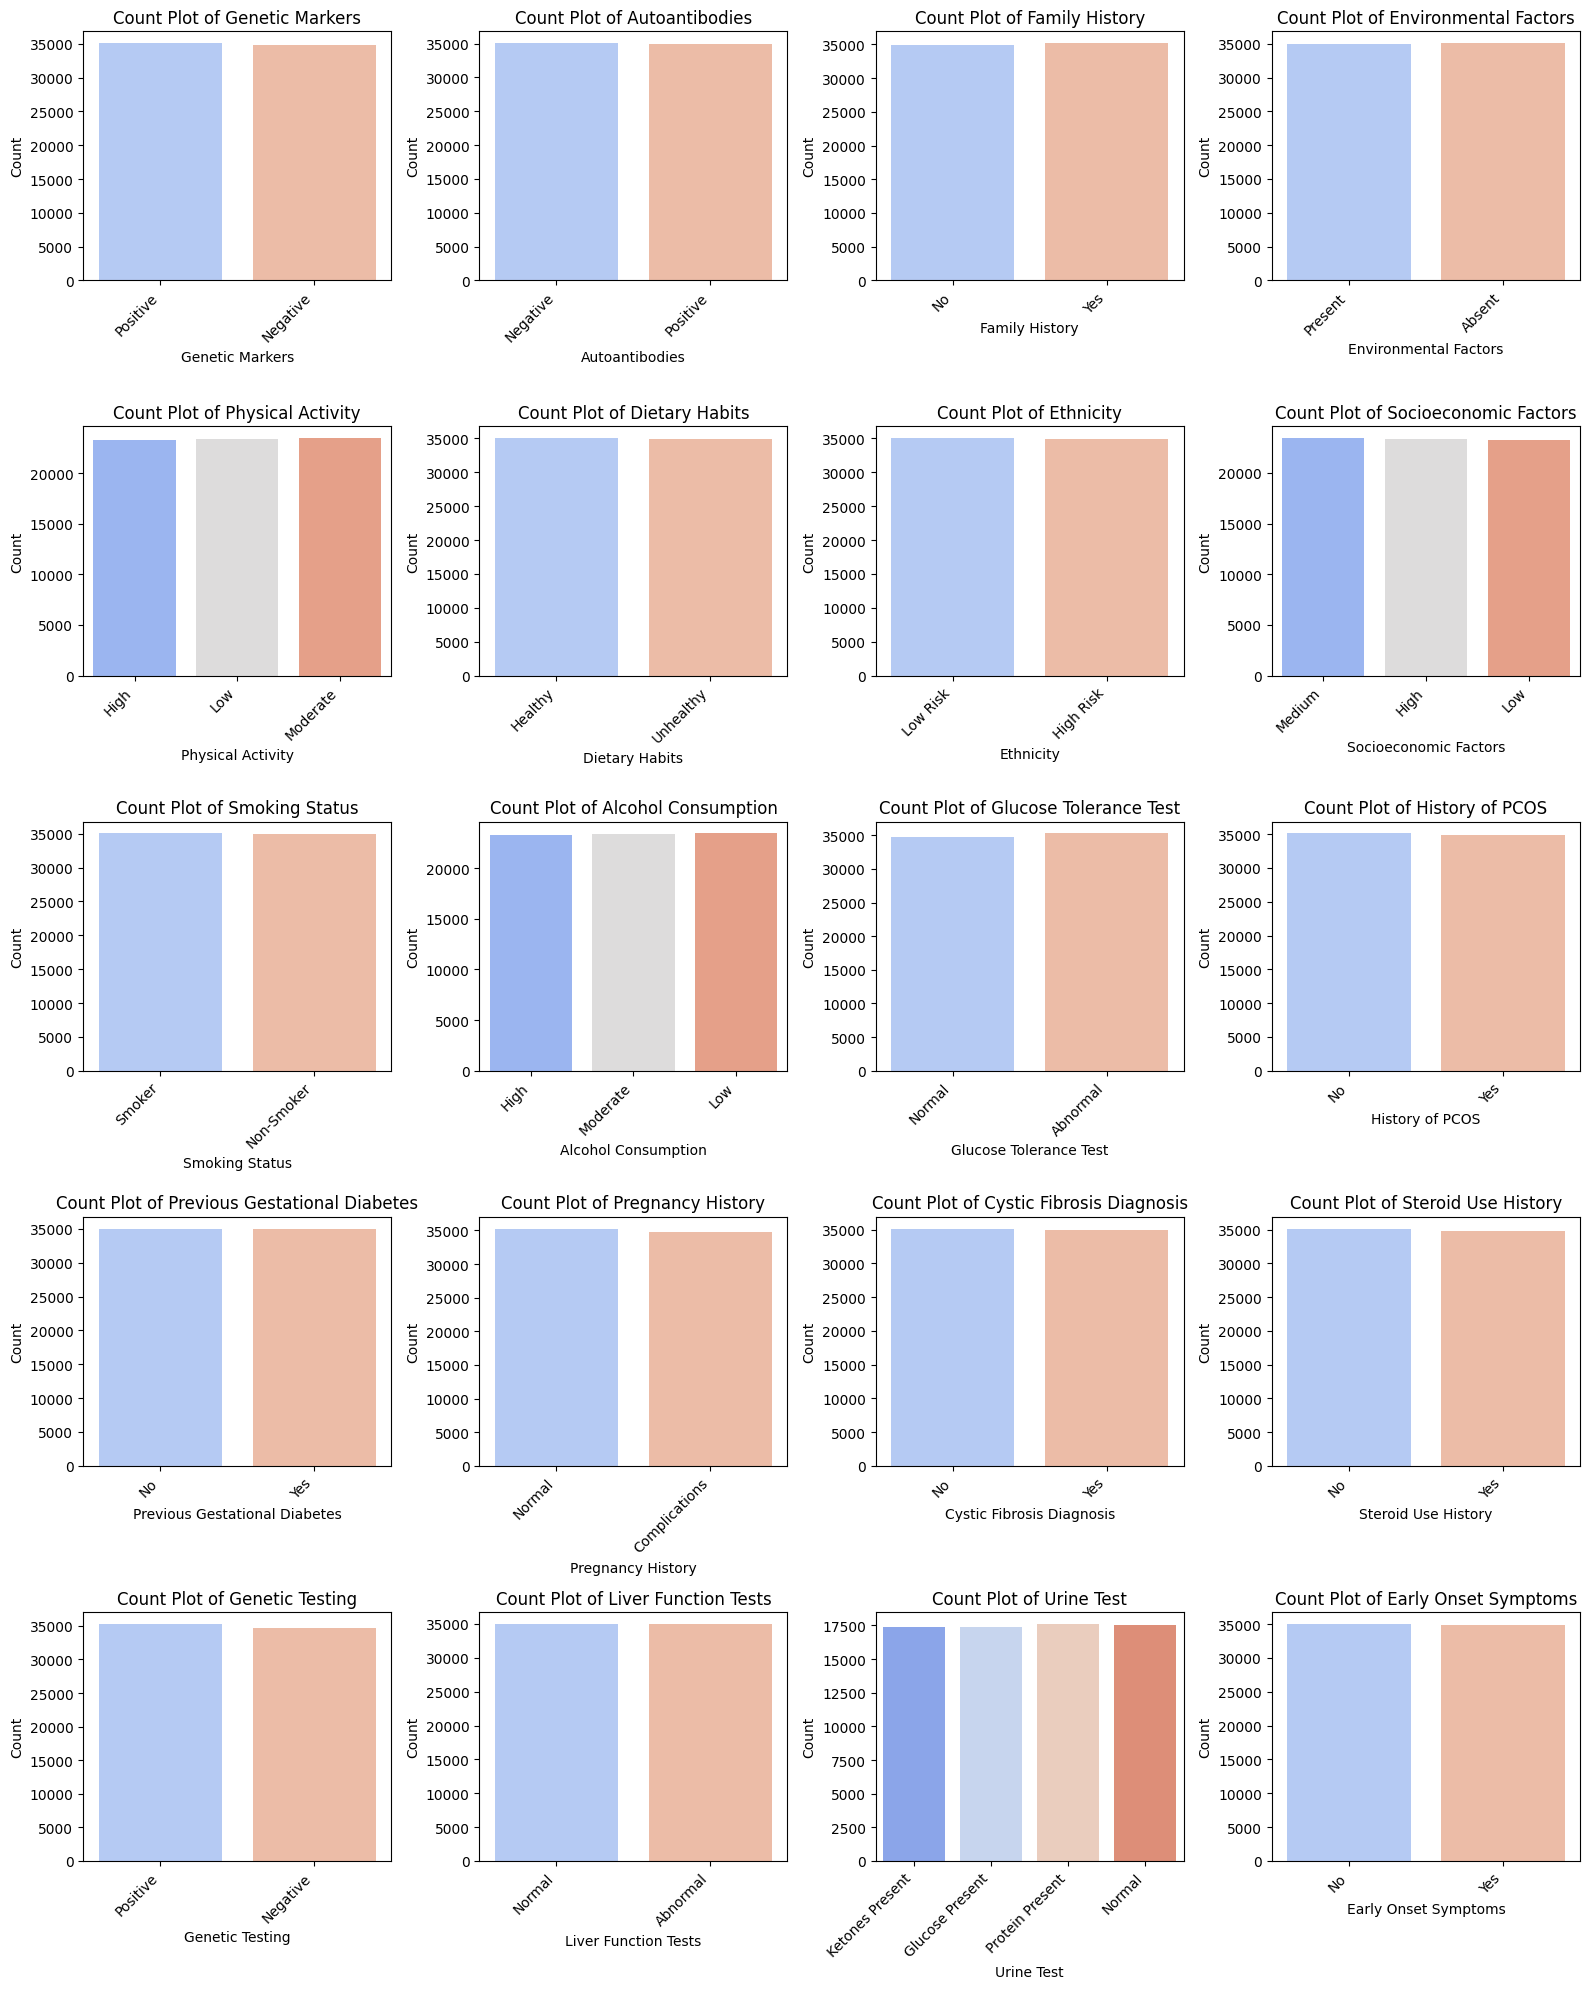

In [12]:
plot_categorical_analysis(df, categorical_features)

Analyse and visualize the class distribution for the target variable to check if there's imbalance for target class

In [13]:
# Check class distribution (imbalance check)
class_distribution = df.iloc[:, 0].value_counts(normalize=True) * 100
class_distribution

Target
MODY                                          7.932857
Secondary Diabetes                            7.827143
Cystic Fibrosis-Related Diabetes (CFRD)       7.805714
Type 1 Diabetes                               7.780000
Neonatal Diabetes Mellitus (NDM)              7.725714
Wolcott-Rallison Syndrome                     7.714286
Type 2 Diabetes                               7.710000
Prediabetic                                   7.680000
Gestational Diabetes                          7.634286
Type 3c Diabetes (Pancreatogenic Diabetes)    7.600000
Wolfram Syndrome                              7.592857
Steroid-Induced Diabetes                      7.535714
LADA                                          7.461429
Name: proportion, dtype: float64

C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\471757492.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.iloc[:, 0], palette="coolwarm")
C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\471757492.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


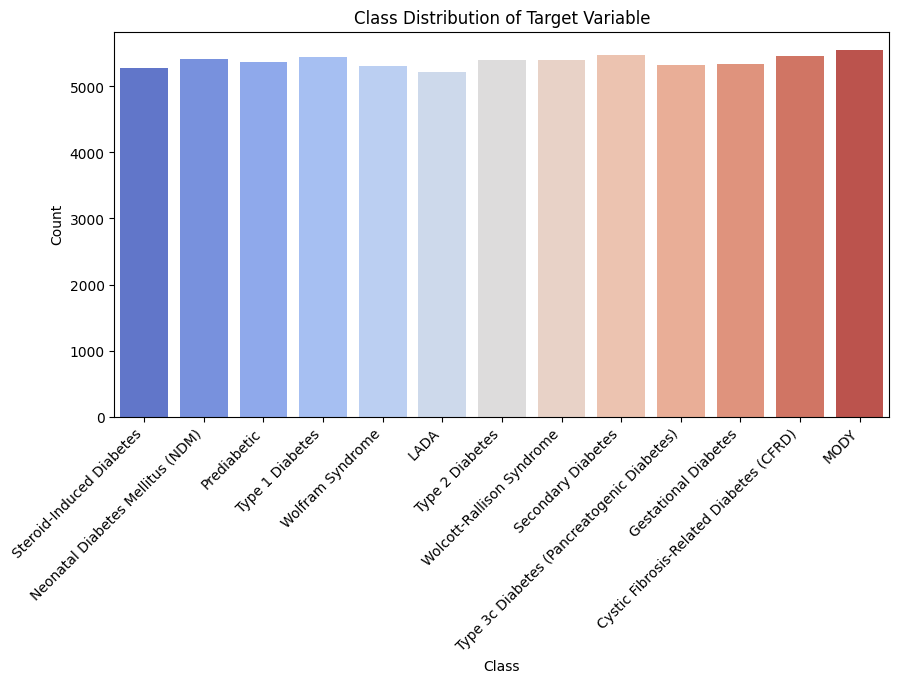

In [14]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df.iloc[:, 0], palette="coolwarm")

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.title("Class Distribution of Target Variable")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Outlier Detection

In [15]:
def count_outliers(df, numerical_features):
    outliers_count = {}
    
    for column in numerical_features:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_count[column] = outliers.shape[0]
    
    return outliers_count

outliers_count = count_outliers(df, numerical_features)
outliers_count

{'Insulin Levels': 0,
 'Age': 0,
 'BMI': 0,
 'Blood Pressure': 0,
 'Cholesterol Levels': 0,
 'Waist Circumference': 522,
 'Blood Glucose Levels': 0,
 'Weight Gain During Pregnancy': 0,
 'Pancreatic Health': 0,
 'Pulmonary Function': 1206,
 'Neurological Assessments': 0,
 'Digestive Enzyme Levels': 0,
 'Birth Weight': 0}

In [16]:
def plot_boxplot(data, features):
    plt.figure(figsize=(15, 15))

    num_columns = 3
    num_rows = math.ceil(len(features) / num_columns)

    for i, col in enumerate(features, 1):
        plt.subplot(num_rows, num_columns, i)
        sns.boxplot(x=data[col])
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

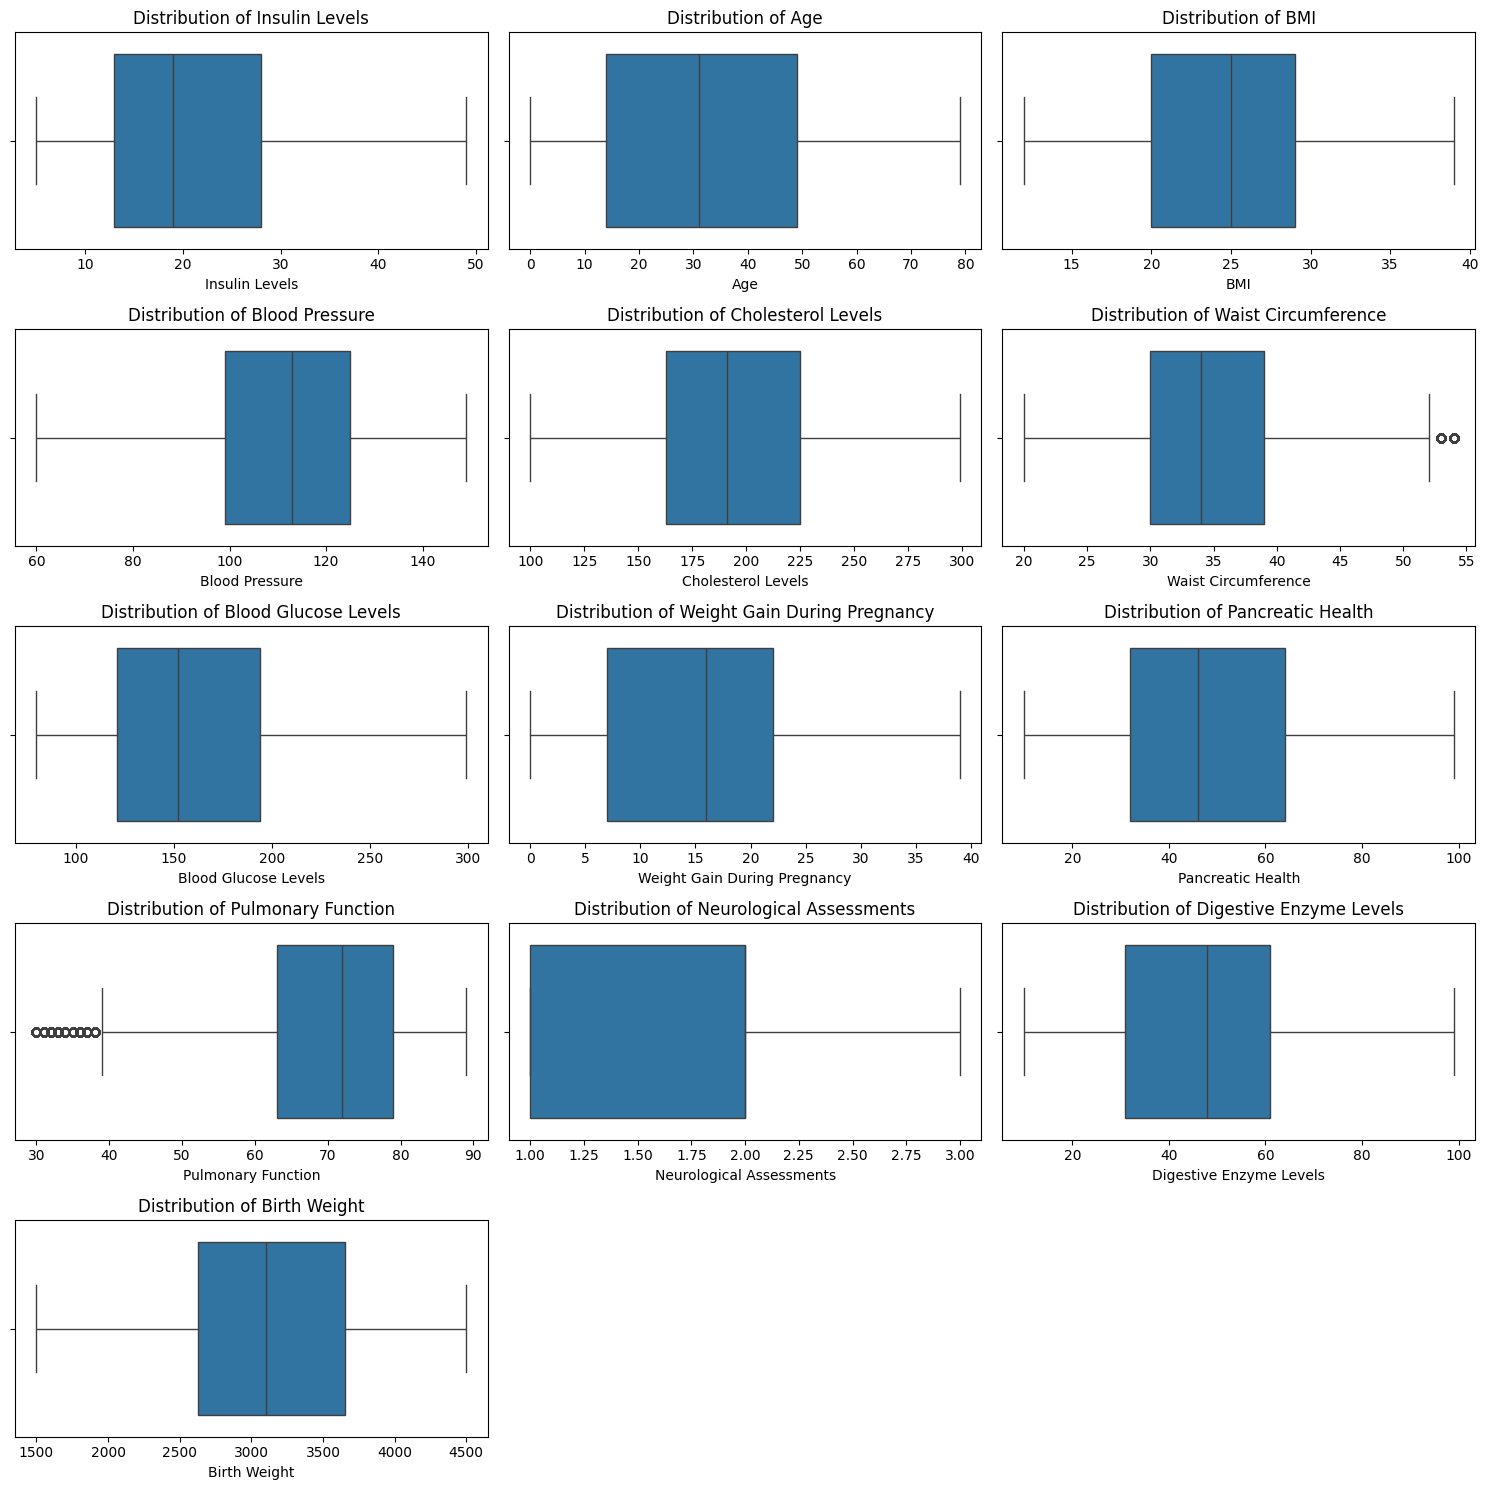

In [17]:
plot_boxplot(df, numerical_features)

### Correlation Analysis

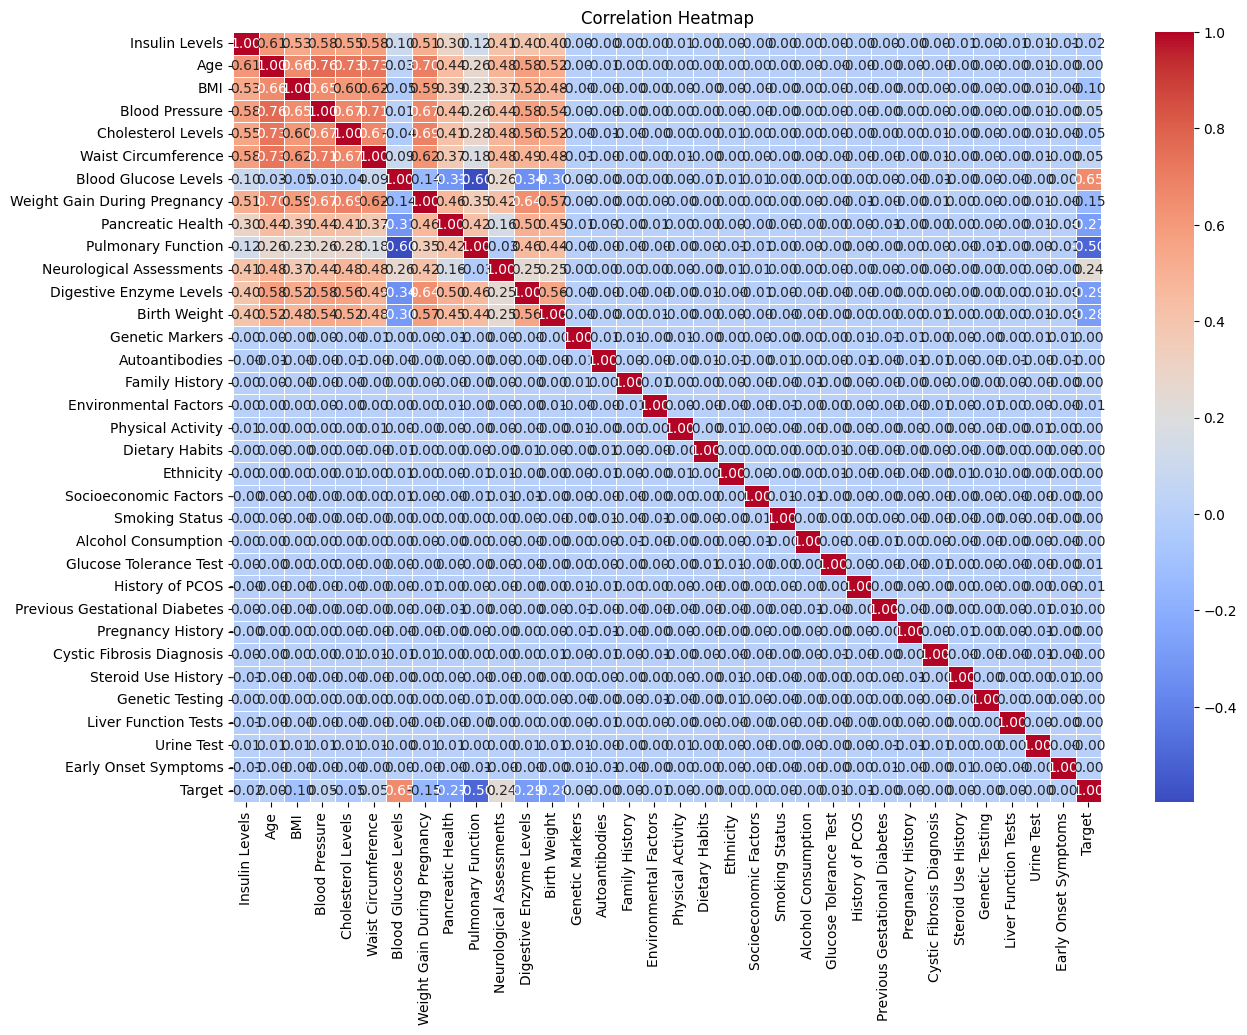

In [18]:
# Create a copy of the dataset for encoding
df_encoded = df.copy()

# Apply Label Encoding to categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Encode the target variable
target_encoder = LabelEncoder()
df_encoded[target_column[0]] = target_encoder.fit_transform(df_encoded[target_column[0]])

# Compute correlation matrix including both numerical, categorical, and target variable
correlation_matrix_full = df_encoded[numerical_features + categorical_features + target_column].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_full, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


### Feature-Target Relationship

C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\1733306179.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target_column[0]], y=df[column], ax=ax, palette="coolwarm")
C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\1733306179.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability
C:\Users\azri2\AppData\Local\Temp\ipykernel_16400\1733306179.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target_column[0]], y=df[column], ax=ax, palette="coolwarm")
C:\Users\azri2\AppData\Local\Temp\ip

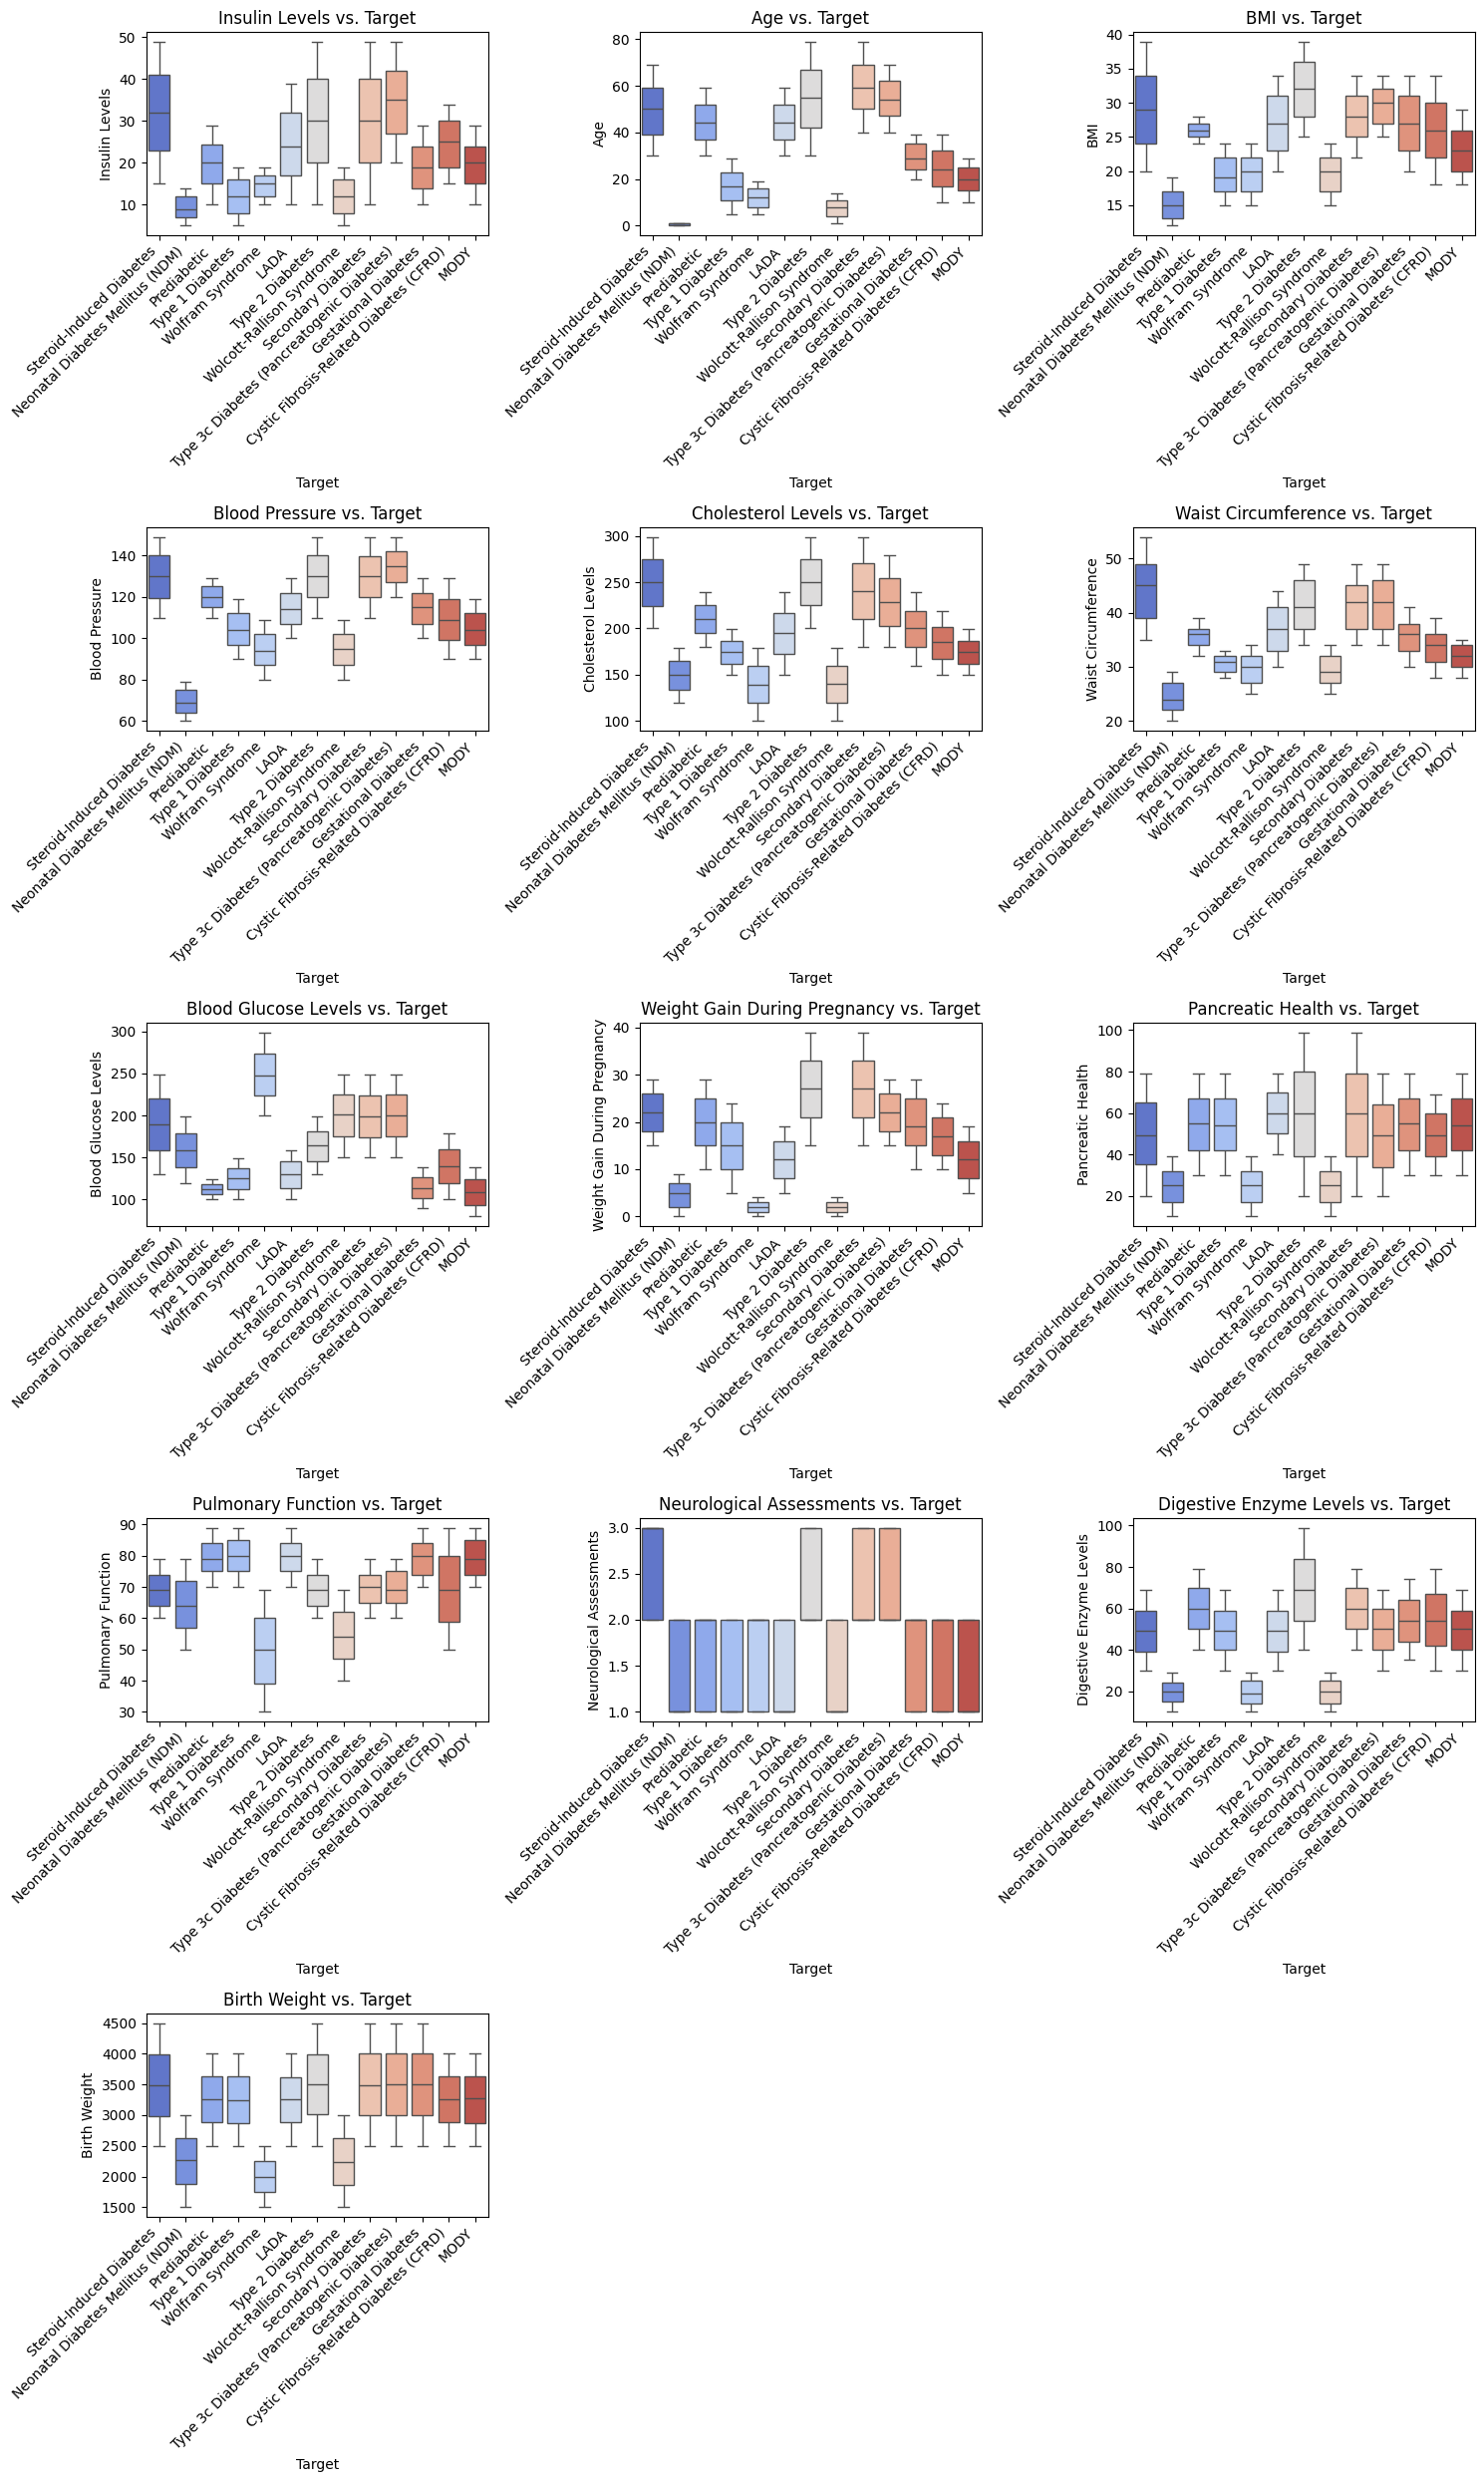

In [19]:
def plot_feature_target_relationship(df, numerical_features, target_column):
    # Define layout parameters
    columns_per_row = 3  # Adjust the number of columns per row for better visualization
    num_columns = len(numerical_features)
    num_rows = math.ceil(num_columns / columns_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten for easier iteration

    # Loop through numerical features and create boxplots
    for idx, column in enumerate(numerical_features):
        ax = axes[idx]  # Select the appropriate subplot
        sns.boxplot(x=df[target_column[0]], y=df[column], ax=ax, palette="coolwarm")
        ax.set_title(f'{column} vs. {target_column[0]}')
        ax.set_xlabel(target_column[0])
        ax.set_ylabel(column)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability

    # Hide unused subplots if any
    for idx in range(num_columns, len(axes)):
        axes[idx].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Run the function to analyze feature-target relationships
plot_feature_target_relationship(df, numerical_features, target_column)


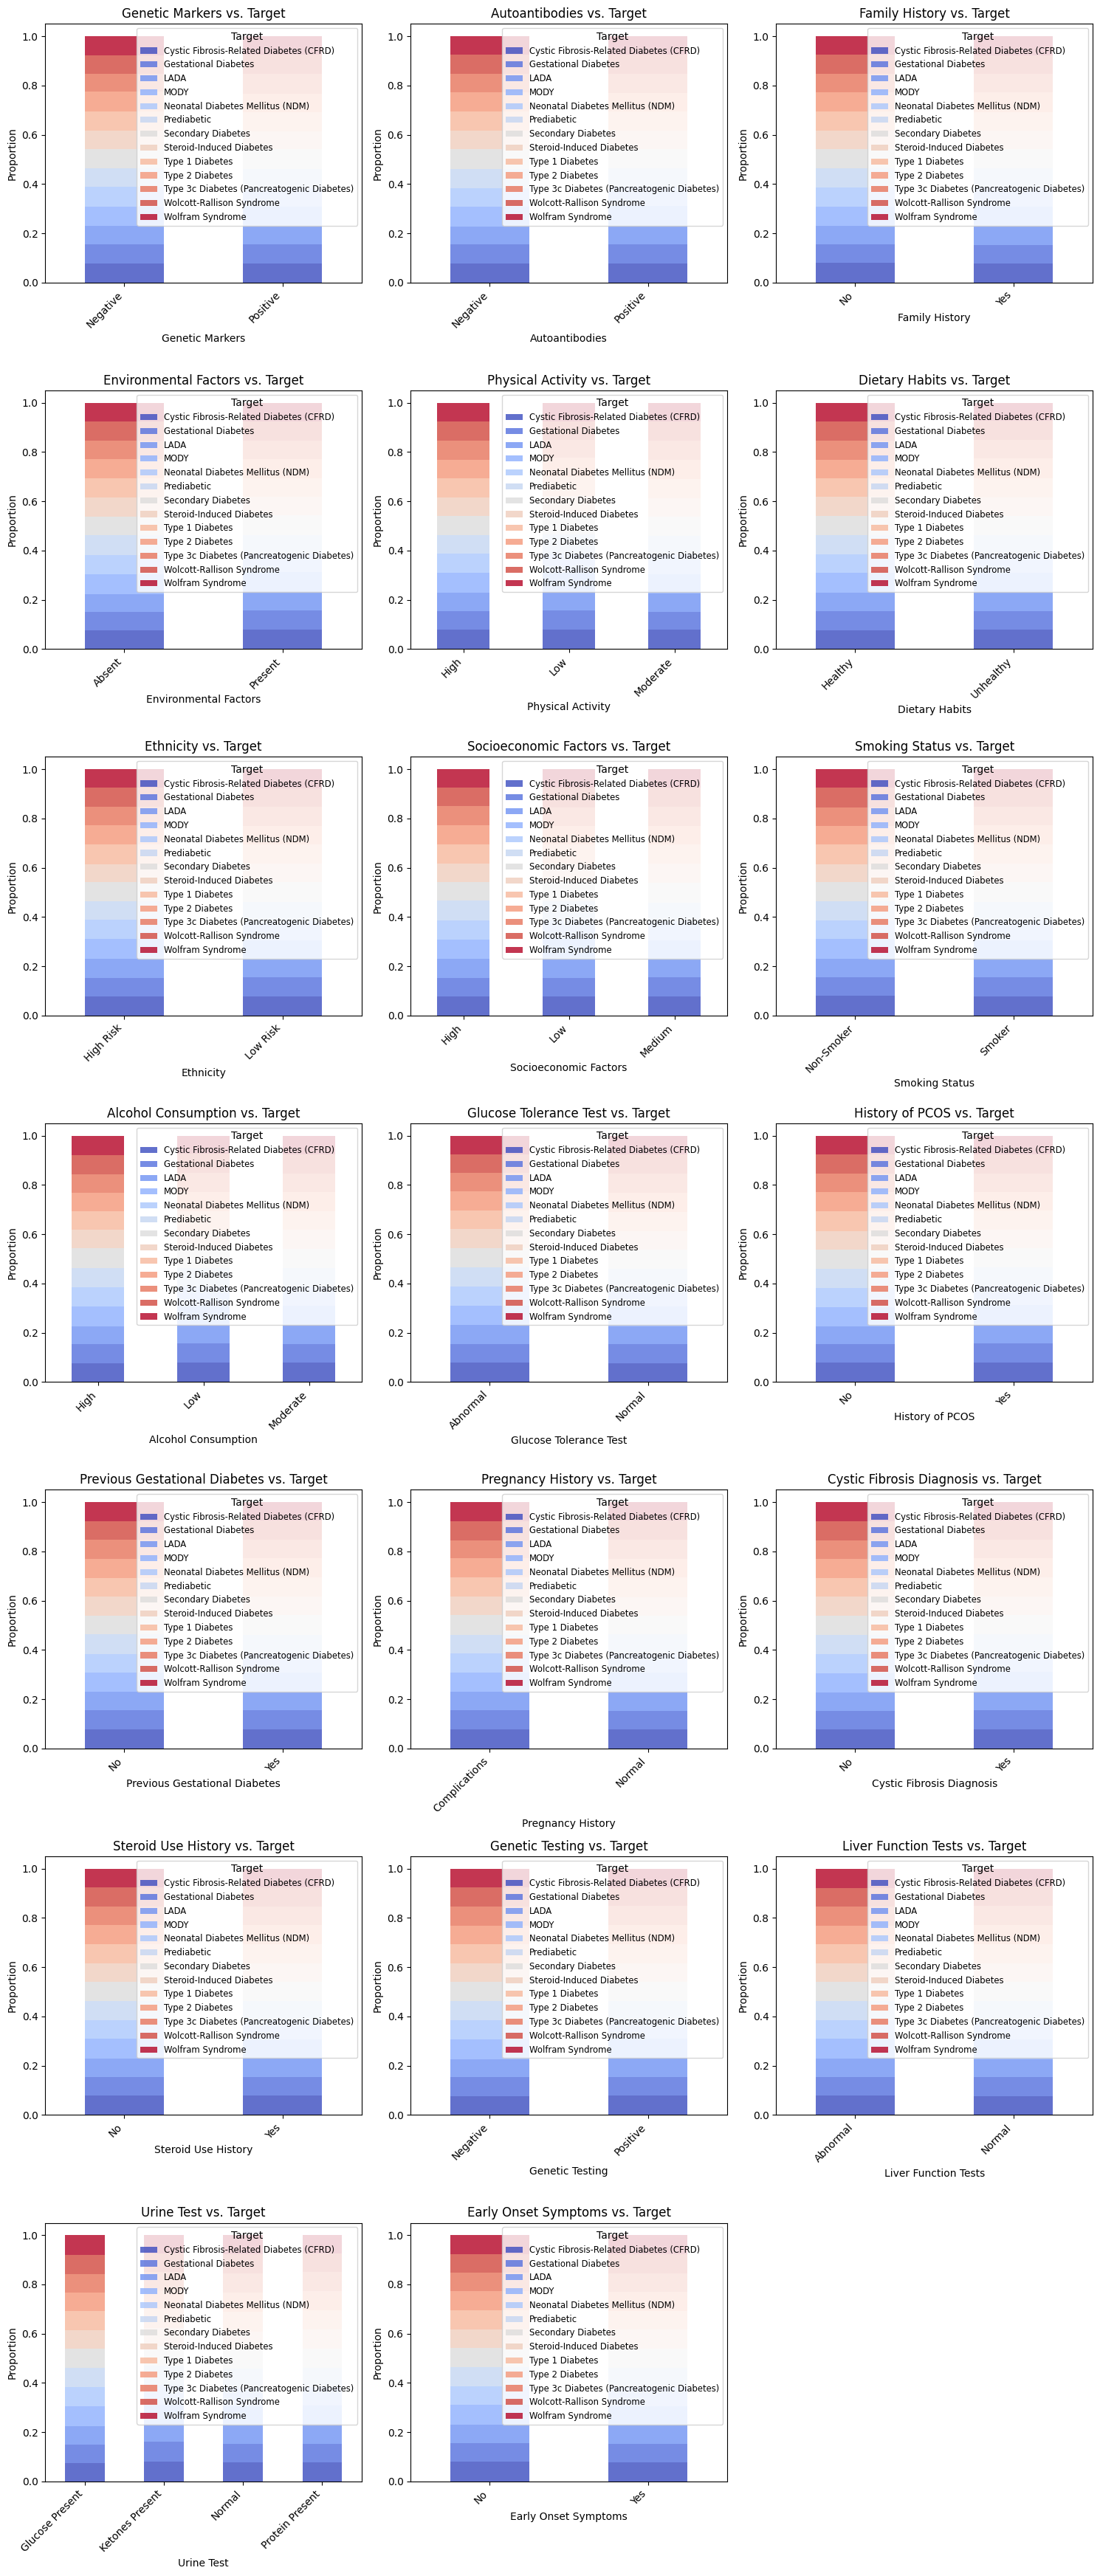

In [20]:
# Function to plot categorical feature-target relationships
def plot_categorical_feature_target_relationship(df, categorical_features, target_column):
    # Define layout parameters
    columns_per_row = 3  # Adjust the number of columns per row for better visualization
    num_columns = len(categorical_features)
    num_rows = math.ceil(num_columns / columns_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten for easier iteration

    # Loop through categorical features and create stacked bar charts
    for idx, column in enumerate(categorical_features):
        ax = axes[idx]  # Select the appropriate subplot
        
        # Create a normalized stacked bar plot
        category_target_counts = pd.crosstab(df[column], df[target_column[0]], normalize='index')
        category_target_counts.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm', alpha=0.8)

        ax.set_title(f'{column} vs. {target_column[0]}')
        ax.set_xlabel(column)
        ax.set_ylabel("Proportion")
        ax.legend(title=target_column[0], loc="upper right", fontsize="small")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability

    # Hide unused subplots if any
    for idx in range(num_columns, len(axes)):
        axes[idx].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Run the function to analyze categorical feature-target relationships
plot_categorical_feature_target_relationship(df, categorical_features, target_column)


all seems uniform, so we run chi-square test to check for more detailed statistics

In [21]:
# Function to perform Chi-Square test for categorical features vs. target variable
def chi_square_test(df, categorical_features, target_column):
    chi_square_results = {}
    
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df[target_column[0]])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        chi_square_results[feature] = {"Chi-Square Statistic": chi2, "p-value": p}
    
    return pd.DataFrame.from_dict(chi_square_results, orient='index')

# Run Chi-Square test
chi_square_results_df = chi_square_test(df, categorical_features, target_column)
chi_square_results_df


,Chi-Square Statistic,p-value
Genetic Markers,28.122805,0.005308
Autoantibodies,6.906988,0.863698
Family History,4.866510,0.962289
Environmental Factors,15.950655,0.193507
Physical Activity,29.271103,0.210095
Dietary Habits,9.935614,0.621609
Ethnicity,11.601231,0.478213
Socioeconomic Factors,29.802274,0.191392
Smoking Status,12.189021,0.430621
Alcohol Consumption,21.348460,0.618093


# Data Preprocessing

In [22]:
# Create a copy of the dataset
df_copy = df.copy()

### Missing & Duplicated Values

No handling needed.

### Handle Outliers

In [23]:
# Apply Winsorization for both Pulmonary Function and Waist Circumference
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    
    return lower_bound, upper_bound

# Apply capping to both features and get bounds
lower_bound_pulmonary, upper_bound_pulmonary = cap_outliers(df_copy, "Pulmonary Function")
lower_bound_waist, upper_bound_waist = cap_outliers(df_copy, "Waist Circumference")

# Verify if outliers are now handled
updated_outliers_count = {
    "Pulmonary Function": ((df_copy["Pulmonary Function"] < lower_bound_pulmonary) | (df_copy["Pulmonary Function"] > upper_bound_pulmonary)).sum(),
    "Waist Circumference": ((df_copy["Waist Circumference"] < lower_bound_waist) | (df_copy["Waist Circumference"] > upper_bound_waist)).sum()
}

# Display updated outlier count using pandas
updated_outliers_df = pd.DataFrame.from_dict(updated_outliers_count, orient='index', columns=['Outlier Count'])
display(updated_outliers_df)


,Outlier Count
Pulmonary Function,0
Waist Circumference,0


### Train-Test Split

In [25]:
# Define features (X) and target variable (y)
X = df_copy.drop(columns=["Target"])  # All features except target
y = df_copy["Target"]  # Target variable

# Perform Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Transformation

In [26]:
# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le  

# Label encode the target variable
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

In [27]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### Feature Selection

In [28]:
# Initialize RandomForest for Boruta
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [29]:
# Initialize Boruta Feature Selection
boruta_selector = BorutaPy(rf, random_state=42)

In [30]:
# Fit Boruta on training data
boruta_selector.fit(X_train.values, y_train)

BorutaPy(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2CE0EDED840),
         random_state=RandomState(MT19937) at 0x2CE0EDED840)

In [31]:
# Get selected feature names using support_
selected_features = X_train.columns[boruta_selector.support_].tolist()

# Print selected features
selected_features

['Insulin Levels',
 'Age',
 'BMI',
 'Blood Pressure',
 'Cholesterol Levels',
 'Waist Circumference',
 'Blood Glucose Levels',
 'Weight Gain During Pregnancy',
 'Pancreatic Health',
 'Pulmonary Function',
 'Neurological Assessments',
 'Digestive Enzyme Levels',
 'Birth Weight']

In [32]:
# Keep only selected features in dataset
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Model Training

In [33]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)

c:\Users\azri2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model Evaluation

In [34]:
# Initialize a dictionary to store classification reports and ROC-AUC scores for each model
model_evaluation = {}

# Loop through each model and evaluate
for model_name, model in models.items():
    y_pred = model.predict(X_test_selected)
    
    # Generate classification report
    classification_rep = classification_report(y_test, y_pred, target_names=target_encoder.classes_, output_dict=True)

    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_selected)  # MODIFIED: Now using probability scores
    else:
        y_prob = None  # Fallback for models that don't support probability predictions

    # Calculate ROC-AUC score for each class
    roc_auc_scores = {}
    for i in range(len(target_encoder.classes_)):
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])  # MODIFIED: Uses probability scores
            roc_auc_scores[target_encoder.classes_[i]] = roc_auc_score(y_test == i, y_prob[:, i])  # MODIFIED: Uses probability scores
        else:
            fpr, tpr, _ = roc_curve(y_test == i, y_pred == i)  # Fallback if no probability scores
            roc_auc_scores[target_encoder.classes_[i]] = roc_auc_score(y_test == i, y_pred == i)

    # Store the results in the dictionary
    model_evaluation[model_name] = {
        "Classification Report": classification_rep,
        "ROC-AUC Scores": roc_auc_scores
    }

In [35]:
# Convert the evaluation results to a DataFrame for better display
evaluation_df = pd.DataFrame({
    model_name: {
        "Accuracy": model_evaluation[model_name]["Classification Report"]["accuracy"],  # Extract accuracy from classification report
        "Precision": model_evaluation[model_name]["Classification Report"]["weighted avg"]["precision"],
        "Recall": model_evaluation[model_name]["Classification Report"]["weighted avg"]["recall"],
        "F1-Score": model_evaluation[model_name]["Classification Report"]["weighted avg"]["f1-score"],
        "ROC-AUC": np.mean(list(model_evaluation[model_name]["ROC-AUC Scores"].values()))
    }
    for model_name in model_evaluation
}).T

# Display the evaluation DataFrame
evaluation_df

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.760143,0.759417,0.760143,0.759629,0.982335
Support Vector Machine,0.828000,0.829923,0.828000,0.827176,0.989233
Decision Tree,0.861071,0.861633,0.861071,0.861230,0.924735
Random Forest,0.900500,0.905190,0.900500,0.899459,0.995475
K-Nearest Neighbors,0.760071,0.765627,0.760071,0.758766,0.956844
Naive Bayes,0.824786,0.825300,0.824786,0.824458,0.989529
Gradient Boosting,0.898429,0.903227,0.898429,0.897126,0.996030
XGBoost,0.896643,0.898161,0.896643,0.895632,0.996066


Save models, encoders, scalers and selected features for Streamlit Deployment

In [ ]:
# Create a directory for saved models if it doesn't exist
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

# Save trained models
for model_name, model in models.items():
    joblib.dump(model, f"saved_models/{model_name}.pkl")

# Save label encoders for categorical features
joblib.dump(label_encoders, "saved_models/label_encoders.pkl")

# Save label encoder for target variable
joblib.dump(target_encoder, "saved_models/target_encoder.pkl")

# Save scaler for numerical features
joblib.dump(scaler, "saved_models/scaler.pkl")

# Save selected features
joblib.dump(selected_features, "saved_models/selected_features.pkl")

print("All models, encoders, and scaler saved successfully!")


✅ All models, encoders, and scaler saved successfully!
